In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pdb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from sys import platform

DEVICE = 'mps' if platform == 'darwin' else 'cuda'
if DEVICE == 'mps':
    DOWNLOAD_PATH = '/Users/georgestoica/Downloads' 
else:
    DOWNLOAD_PATH = '/srv/share/gstoica3/checkpoints/REPAIR/'
    
torch.autograd.set_grad_enabled(False)

from copy import deepcopy
from collections import defaultdict

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from resnets import resnet20
from matching_algs import *
from model_matchings import *

In [4]:
def save_model(model, i):
    sd = model.state_dict()
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    torch.save(model.state_dict(), path)

def load_model(model, i):
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    sd = torch.load(path, map_location=torch.device(DEVICE))
    model.load_state_dict(sd)
    return model


In [5]:
cifar100_info = {
    'dir': '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python',
    'classes1': np.arange(50),
    'classes2': np.arange(50, 100),
    'num_classes': 100,
    'split_classes': 50,
    'wrapper': torchvision.datasets.CIFAR100
}

cifar10_info = {
    'dir': '/tmp',
    'classes1': np.array([3, 2, 0, 6, 4]),
    'classes2': np.array([5, 7, 9, 8, 1]),
    'num_classes': 10,
    'split_classes': 5,
    'wrapper': torchvision.datasets.CIFAR10
}

ds_info = cifar10_info

In [6]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = ds_info['wrapper'](root=ds_info['dir'], train=True,
                                        download=True, transform=train_transform)
test_dset = ds_info['wrapper'](root=ds_info['dir'], train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:01<00:00, 87824910.04it/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp
Files already downloaded and verified


In [7]:
train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

model1_classes= ds_info['classes1']#np.array([3, 2, 0, 6, 4])
model2_classes = ds_info['classes2']

valid_examples1 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model1_classes]
valid_examples2 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model2_classes]

assert len(set(valid_examples1).intersection(set(valid_examples2))) == 0, 'sets should be disjoint'

train_aug_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples1), batch_size=500, shuffle=True, num_workers=8
)
train_aug_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples2), batch_size=500, shuffle=True, num_workers=8
)

test_valid_examples1 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model1_classes]
test_valid_examples2 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model2_classes]

test_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples1), batch_size=500, shuffle=False, num_workers=8
)
test_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples2), batch_size=500, shuffle=False, num_workers=8
)

50000it [00:14, 3371.31it/s]
50000it [00:14, 3406.61it/s]
10000it [00:01, 5159.86it/s]
10000it [00:01, 5208.17it/s]


In [8]:
class_idxs = np.zeros(ds_info['num_classes'], dtype=int)
class_idxs[model1_classes] = np.arange(ds_info['split_classes'])
class_idxs[model2_classes] = np.arange(ds_info['split_classes'])
class_idxs = torch.from_numpy(class_idxs)
print(class_idxs)

tensor([2, 4, 1, 0, 4, 0, 3, 1, 3, 2])


In [9]:
# evaluates accuracy
def evaluate_texthead(model, loader, class_vectors, remap_class_idxs=None, return_confusion=False):
    model.eval()
    correct = 0
    total = 0
    
    totals = [0] * class_vectors.shape[0]
    corrects = [0] * class_vectors.shape[0]
    
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            encodings = model(inputs.to(DEVICE))
            normed_encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            outputs = normed_encodings @ class_vectors.T
            pred = outputs.argmax(dim=1)
            if remap_class_idxs is not None:
                correct += (remap_class_idxs[labels].to(DEVICE) == pred).sum().item()
            else:
                for gt, p in zip(labels, pred):
                    totals[gt] += 1
                    
                    if gt == p:
                        correct += 1
                        corrects[gt] += 1
                
            total += inputs.shape[0]
    if return_confusion:
        return correct / sum(totals), list(map(lambda a: a[0] / a[1], zip(corrects, totals)))
    else:
        return correct / total

In [10]:
import clip

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_dset.classes]).to(DEVICE)
model, preprocess = clip.load('ViT-B/32', DEVICE)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)


text_features /= text_features.norm(dim=-1, keepdim=True)
class_vecs1 = text_features[model1_classes]
class_vecs2 = text_features[model2_classes]

In [11]:
model1 = resnet20(w=4, text_head=True).to(DEVICE)
model2 = resnet20(w=4, text_head=True).to(DEVICE)
load_model(model1, f'resnet20x4_CIFAR5_clses{model1_classes.tolist()}')
load_model(model2, f'resnet20x4_CIFAR5_clses{model2_classes.tolist()}')

print(evaluate_texthead(model1, test_loader1, class_vecs1, remap_class_idxs=class_idxs))
print(evaluate_texthead(model2, test_loader2, class_vecs2, remap_class_idxs=class_idxs))

0.9558
0.9726


In [12]:
def match_tensors_exact_bipartite_abs(
    hull_tensor,
    interleave=False,
    random_perm=False
):
    hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    remainder = int(hull_tensor.shape[0] * (1-r))
    bound = O - remainder
    sims = hull_normed @ hull_normed.transpose(-1, -2)
    sims_abs = sims.abs()
    torch.diagonal(sims_abs)[:] = -torch.inf
    permutation_matrix = torch.zeros((O, O - bound), device=sims.device)
    for i in range(bound):
        best_idx = sims_abs.view(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        permutation_matrix[row_idx, i] = 1
        permutation_matrix[col_idx, i] = 1 * sims[row_idx, col_idx].sign()
        sims_abs[row_idx] = -torch.inf
        sims_abs[col_idx] = -torch.inf
        sims_abs[:, row_idx] = -torch.inf
        sims_abs[:, col_idx] = -torch.inf
    
    unused = (sims_abs.max(-1)[0] > -torch.inf).to(torch.int).nonzero().view(-1)
    for i in range(bound, O-bound):
        permutation_matrix[unused[i-bound], i] = 1
    merge = permutation_matrix / (permutation_matrix.abs().sum(dim=0, keepdim=True) + 1e-5)
    unmerge = permutation_matrix
    return merge.T, unmerge


In [13]:
def match_tensors_exact_bipartite_dist(
    hull_tensor,
    interleave=False,
    random_perm=False
):
    cdists = torch.cdist(hull_tensor, hull_tensor)
#     hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    remainder = int(hull_tensor.shape[0] * (1-r))
    bound = O - remainder
#     sims = hull_normed @ hull_normed.transpose(-1, -2)
    sims = -cdists
    torch.diagonal(sims)[:] = -torch.inf
    permutation_matrix = torch.zeros((O, O - bound), device=sims.device)
    for i in range(bound):
        best_idx = sims.view(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        permutation_matrix[row_idx, i] = 1
        permutation_matrix[col_idx, i] = 1
        sims[row_idx] = -torch.inf
        sims[col_idx] = -torch.inf
        sims[:, row_idx] = -torch.inf
        sims[:, col_idx] = -torch.inf
    
    unused = (sims.max(-1)[0] > -torch.inf).to(torch.int).nonzero().view(-1)
    for i in range(bound, O-bound):
        permutation_matrix[unused[i-bound], i] = 1
    merge = permutation_matrix / (permutation_matrix.sum(dim=0, keepdim=True) + 1e-5)
    unmerge = permutation_matrix
    return merge.T, unmerge


In [14]:
def match_tensors_exact_bipartite(
    hull_tensor,
    interleave=False,
    random_perm=False
):
    hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    remainder = int(hull_tensor.shape[0] * (1-r))
    bound = O - remainder
    sims = hull_normed @ hull_normed.transpose(-1, -2)
    torch.diagonal(sims)[:] = -torch.inf
    permutation_matrix = torch.zeros((O, O - bound), device=sims.device)
    merged_sims = []
    for i in range(bound):
        best_idx = sims.view(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        permutation_matrix[row_idx, i] = 1
        permutation_matrix[col_idx, i] = 1
        sims[row_idx] = -torch.inf
        sims[col_idx] = -torch.inf
        sims[:, row_idx] = -torch.inf
        sims[:, col_idx] = -torch.inf
        merged_sims.append(sims.view(-1).max().cpu().numpy().tolist())
    
    unused = (sims.max(-1)[0] > -torch.inf).to(torch.int).nonzero().view(-1)
    for i in range(bound, O-bound):
        permutation_matrix[unused[i-bound], i] = 1
    merge = permutation_matrix / (permutation_matrix.sum(dim=0, keepdim=True) + 1e-5)
    unmerge_a, unmerge_b = permutation_matrix.chunk(2, dim=0)
    unmerge_a = unmerge_a / (unmerge_a.sum(dim=0) + 1e-5)
    unmerge_b = unmerge_b / (unmerge_b.sum(dim=0) + 1e-5)
    unmerge = concat_mats((unmerge_a, unmerge_b), dim=0)
#     print(np.round(merged_sims, 3))
    return merge.T, unmerge


In [70]:
def match_tensors_PAN(
    hull_tensor,
    interleave=False,
    random_perm=False,
):
    hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    remainder = int(hull_tensor.shape[0] * (1-r))
    bound = O - remainder
    sims = hull_normed @ hull_normed.transpose(-1, -2)
    
    hull_a, hull_b = hull_tensor.chunk(2, dim=0)
    c_aa = hull_a.any(dim=0, keepdim=True).float()
    c_bb = hull_b.any(dim=0, keepdim=True).float()
    c_ab = (c_aa * c_bb)
    
    hull_a = F.normalize(hull_a * c_ab, dim=-1)
    hull_b = F.normalize(hull_b * c_ab, dim=-1)
    sims_ab = hull_a @ hull_b.transpose(-1, -2)
    half_O = O // 2
    sims[half_O:, :half_O] = sims_ab
    sims[:half_O, half_O:] = sims_ab.T
    
    torch.diagonal(sims)[:] = -torch.inf
    permutation_matrix = torch.zeros((O, O - bound), device=sims.device)
    merged_sims = []
    
    for i in range(bound):
#         if i % 3 in {0}: # Get AB permutation
#             temp_sims = sims.clone()
#             temp_sims[:half_O, :half_O] = -torch.inf
#             temp_sims[half_O:, half_O:] = -torch.inf
#         elif i % 3 in {1}: # Get AA permutation
#             temp_sims = sims.clone()
#             temp_sims[half_O:] = -torch.inf
#             temp_sims[:half_O, half_O:] = -torch.inf
#         elif i % 3 in {2}: # Get BB permutation
#             temp_sims = sims.clone()
#             temp_sims[:, :half_O] = -torch.inf
#             temp_sims[:half_O, half_O:] = -torch.inf
        temp_sims = sims
            
        best_idx = temp_sims.view(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        permutation_matrix[row_idx, i] = 1
        permutation_matrix[col_idx, i] = 1
        sims[row_idx] = -torch.inf
        sims[col_idx] = -torch.inf
        sims[:, row_idx] = -torch.inf
        sims[:, col_idx] = -torch.inf
        merged_sims.append(sims.view(-1).max().cpu().numpy().tolist())
    
    unused = (sims.max(-1)[0] > -torch.inf).to(torch.int).nonzero().view(-1)
    for i in range(bound, O-bound):
        permutation_matrix[unused[i-bound], i] = 1
    merge = permutation_matrix / (permutation_matrix.sum(dim=0, keepdim=True) + 1e-5)
    
    unmerge_a, unmerge_b = permutation_matrix.chunk(2, dim=0)
    unmerge_a = unmerge_a / (unmerge_a.sum(dim=0) + 1e-5)
    unmerge_b = unmerge_b / (unmerge_b.sum(dim=0) + 1e-5)
    unmerge = concat_mats((unmerge_a, unmerge_b), dim=0)

    return merge.T, unmerge


In [71]:
def find_transform_differences(old_transforms, current_transforms):
    if len(old_transforms) == 0:
        return {}
    transform2norm = {}
    for key, old_transform in old_transforms.items():
        current_transform = current_transforms[key]
        old_align = old_transform.output_align
        new_align = current_transform.output_align
        cost = old_align.T @ new_align
        row_ind, col_idx = scipy.optimize.linear_sum_assignment(cost.detach().cpu().numpy())
        permutation = torch.eye(new_align.shape[1], device=old_align.device)[col_idx]
        aligned_new = new_align @ permutation
#         pdb.set_trace()
        norm = torch.norm(old_align - aligned_new).cpu().numpy()
        transform2norm[key] = norm
    return transform2norm

In [72]:
r = 0.5
fn = match_tensors_PAN
ignore_mismatches=True
set_r(r)
set_match_fn(fn)

match_tensors = match_wrapper(
    fn, 
    backend_alg=match_tensors_PAN_incomplete,
    interleave=True, 
    random_perm=False
)
layer_transform = lambda : LayerTransform(normalize_tensors=True, tensor_merge_type='concat')
old_state_dict = {}
state_dict = {}
old_transforms = defaultdict(lambda: layer_transform())
new_transforms = defaultdict(lambda: layer_transform())
modelc = resnet20(w=4, text_head=True).to(DEVICE)
accuracies = []
steps = []
distances = []
best_info = {'acc': 0., 'dist': np.inf}
step = 1
is_converged = False
prev_distance = np.inf
same_window = 5
same_span = 0
while not is_converged:
# for step in tqdm(range(121)):
    old_transforms = new_transforms
    old_state_dict = deepcopy(state_dict)
    new_transforms = merge_resnet20(
        state_dict, 
        model1, 
        model2, 
        transforms=deepcopy(old_transforms),
        concat_head=False,
        ignore_mismatches=ignore_mismatches
    )
    if step == 0:
        original_computation = deepcopy(new_transforms)

    transform2dist = find_transform_differences(old_transforms, new_transforms)
    avg_distance = np.mean(list(transform2dist.values()))
    
    if abs(avg_distance - prev_distance) <= 1e-5:
        same_span += 1
    else:
        same_span = 0
    if same_span >= same_window:
        is_converged = True
    print(step, avg_distance)
    prev_distance = avg_distance
#     is_converged = True
    if is_converged or step >= 100:
        break
    step += 1

1 nan
2 12.606273
3 12.606273
4 12.606273
5 12.603865
6 12.606273
7 12.606273
8 12.606273
9 12.606273
10 12.606273
11 12.606273


In [65]:
step

96

In [73]:
modelc.load_state_dict(state_dict)
reset_bn_stats(modelc, loader=train_aug_loader)
acc, perclass_acc = evaluate_texthead(
    modelc, test_loader, class_vectors=text_features, return_confusion=True
)
acc

0.1

In [74]:
print(perclass_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


# Transforms

In [75]:
output_aligns = {k: new_transforms[k].output_align.chunk(2, dim=-1) for k in new_transforms.keys()}

input_aligns = {k: new_transforms[k].next_input_align.chunk(2, dim=-1) for k in new_transforms.keys() if new_transforms[k].next_input_align is not None}

In [76]:
key2merges = {}
for key, parts in output_aligns.items():
    A, B = parts
    A_merges = (A.sum(1)*2).abs().ceil().to(torch.int).bincount()[1:]
    B_merges = (B.sum(1)*2).abs().ceil().to(torch.int).bincount()[1:]
    merges = {}
    if len(A_merges) == 2:
        merges['A->A'] = A_merges[1].cpu().numpy()
    if len(B_merges) == 2:
        merges['B->B'] = B_merges[1].cpu().numpy()
    try:
        merges['A^B'] = A_merges[0].cpu().numpy()
    except:
        merges['A^B'] = B_merges[0].cpu().numpy()
    key2merges[key] = merges

key2merges_inp = {}
for key, parts in input_aligns.items():
    A, B = parts
    A_merges = (A.sum(1)).abs().ceil().to(torch.int).bincount()[1:]
    B_merges = (B.sum(1)).abs().ceil().to(torch.int).bincount()[1:]
    merges = {}
    if len(A_merges) == 2:
        merges['A->A'] = A_merges[1].cpu().numpy()
    if len(B_merges) == 2:
        merges['B->B'] = B_merges[1].cpu().numpy()
    merges['A^B'] = A_merges[0].cpu().numpy()
    key2merges_inp[key] = merges
    

In [77]:
for key, merges in key2merges.items():
    print(key, merges)

conv1 {'A->A': array(3), 'B->B': array(3), 'A^B': array(58)}
block1.0 {'A->A': array(32), 'B->B': array(32), 'A^B': array(0)}
block1.1 {'A->A': array(31), 'B->B': array(31), 'A^B': array(2)}
block1.2 {'A->A': array(31), 'B->B': array(31), 'A^B': array(2)}
block2.0 {'A->A': array(63), 'B->B': array(63), 'A^B': array(2)}
block2 {'A->A': array(64), 'B->B': array(64), 'A^B': array(0)}
block2.1 {'A->A': array(7), 'B->B': array(7), 'A^B': array(114)}
block2.2 {'A->A': array(4), 'B->B': array(4), 'A^B': array(120)}
block3.0 {'A->A': array(127), 'B->B': array(127), 'A^B': array(2)}
block3 {'A->A': array(128), 'B->B': array(128), 'A^B': array(0)}
block3.1 {'A->A': array(127), 'B->B': array(127), 'A^B': array(2)}
block3.2 {'A->A': array(127), 'B->B': array(127), 'A^B': array(2)}
linear {'A^B': array(512)}


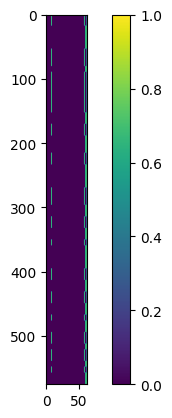

In [108]:
plt.imshow((modelc.layer1[0].conv2.weight.flatten(1).T != 0).cpu().numpy())
plt.colorbar()

In [107]:
print((modelc.layer1[0].conv2.weight.flatten(1).T != 0).float().sum(0, keepdim=True).nonzero().shape)
print((modelc.layer1[0].conv2.weight.flatten(1).T != 0).float().sum(1, keepdim=True).nonzero().shape)

torch.Size([6, 2])
torch.Size([576, 2])


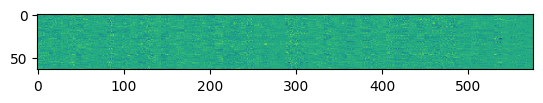

In [81]:
plt.imshow(modelc.layer1[1].conv1.weight.flatten(1).cpu().numpy())

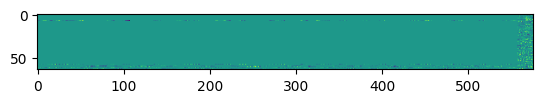

In [82]:
plt.imshow(modelc.layer1[1].conv2.weight.flatten(1).cpu().numpy())

In [60]:
for key, merges in key2merges_inp.items():
    print(key, merges)

conv1 {'A^B': array(64)}
block1.0 {'A^B': array(64)}
block1.1 {'A^B': array(64)}
block1.2 {'A^B': array(64)}
block2.0 {'B->B': array(1), 'A^B': array(128)}
block2 {'B->B': array(1), 'A^B': array(128)}
block2.1 {'A^B': array(128)}
block2.2 {'B->B': array(1), 'A^B': array(128)}
block3.0 {'A^B': array(256)}
block3 {'A^B': array(256)}
block3.1 {'A^B': array(256)}
block3.2 {'A^B': array(256)}


In [72]:
new_transforms['block1.0'].next_input_align.sum(1)

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [125]:
new_transforms['conv1'].output_align[34]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 